In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [7]:
file_path = "stock_data.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['Date'],
    index_col='Date'
)

In [10]:
required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
assert all(col in df.columns for col in required_columns), \
    "Missing required columns in your dataset"

In [11]:
df.ffill(inplace=True)

In [12]:
df['Daily_Return'] = df['Close'].pct_change()

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(df[['Close']])

In [14]:
print("="*50)
print("Dataset Summary")
print("="*50)
print(f"Time Period: {df.index.min()} to {df.index.max()}")
print(f"Total Trading Days: {len(df)}")
print("\nBasic Statistics:")
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())


Dataset Summary
Time Period: 2006-01-03 00:00:00 to 2017-12-29 00:00:00
Total Trading Days: 3019

Basic Statistics:
              Open         High          Low        Close        Volume
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
mean     28.426479    28.766532    28.066558    28.412726  2.158391e+07
std      13.257242    13.356692    13.157326    13.258163  1.926231e+07
min       9.100000     9.480000     8.940000     8.950000  1.939061e+06
25%      16.175000    16.385000    15.970000    16.130000  1.248025e+07
50%      27.180000    27.490000    26.820000    27.100000  1.732130e+07
75%      36.655000    37.035000    36.305000    36.635000  2.512757e+07
max      73.020000    73.250000    72.460000    72.930000  4.382317e+08


In [15]:
plt.figure(figsize=(15, 12))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

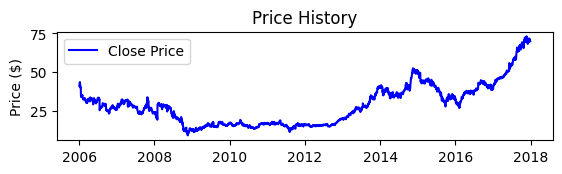

In [16]:
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('Price History')
plt.ylabel('Price ($)')
plt.legend()

Text(0, 0.5, 'Volume')

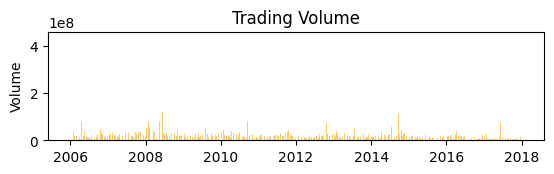

In [17]:
plt.subplot(3, 1, 2)
plt.bar(df.index, df['Volume'], color='orange', alpha=0.6)
plt.title('Trading Volume')
plt.ylabel('Volume')

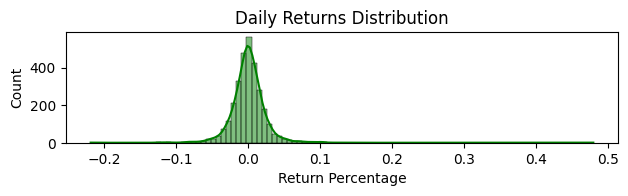

In [18]:
plt.subplot(3, 1, 3)
sns.histplot(df['Daily_Return'].dropna(), bins=100, color='green', kde=True)
plt.title('Daily Returns Distribution')
plt.xlabel('Return Percentage')
plt.tight_layout()
plt.show()

In [19]:
print("\nTensorFlow Configuration:")
print(f"TF Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

print("\nScaled Data Sample (for LSTM):")
print(scaled_prices[:5])


TensorFlow Configuration:
TF Version: 2.15.0
GPU Available: False

Scaled Data Sample (for LSTM):
[[0.4995311 ]
 [0.5004689 ]
 [0.50922163]
 [0.53547984]
 [0.53876211]]


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.utils import dropna
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('stock_data.csv', parse_dates=['Date'], index_col='Date')


In [25]:
assert all(col in df.columns for col in ['Open', 'High', 'Low', 'Close', 'Volume']), \
    "Missing required OHLCV columns"

In [27]:
print(f"Missing values before:\n{df.isna().sum()}")
df.ffill(inplace=True)
print(f"Missing values after:\n{df.isna().sum()}")

Missing values before:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Missing values after:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [28]:
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close']/df['Close'].shift(1))

In [29]:
df = add_all_ta_features(
    df,
    open="Open", high="High", low="Low",
    close="Close", volume="Volume"
)

c:\Users\Mano likhith\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [36]:
selected_features = [
    'Close',
    'trend_macd', 'trend_ema_fast', 'trend_ema_slow',
    'momentum_rsi', 'momentum_stoch',
    'volatility_bbh', 'volatility_bbl',
    'volume_obv', 'volume_cmf'
]
df = df[selected_features]

In [32]:
for lag in [1, 3, 5, 10]:
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)


In [33]:
df['Rolling_7D_Mean'] = df['Close'].rolling(7).mean()
df['Rolling_21D_Vol'] = df['Close'].rolling(21).std()

In [35]:
df.dropna(inplace=True)

In [37]:
split_idx = int(0.8 * len(df))
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

In [38]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']
X_test = test.drop('Close', axis=1)
y_test = test['Close']


In [39]:
scaler_ml = MinMaxScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

In [40]:
scaler_tf = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_tf.fit_transform(y_train.values.reshape(-1, 1))

In [41]:
def create_sequences(features, target, seq_length=30):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

In [42]:
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros(len(X_test_scaled)))


=== Data Summary ===
Original shape: (2994, 10)
Train shapes - ML: (2395, 9), TF: (2365, 30, 9)
Test shapes - ML: (599, 9), TF: (569, 30, 9)


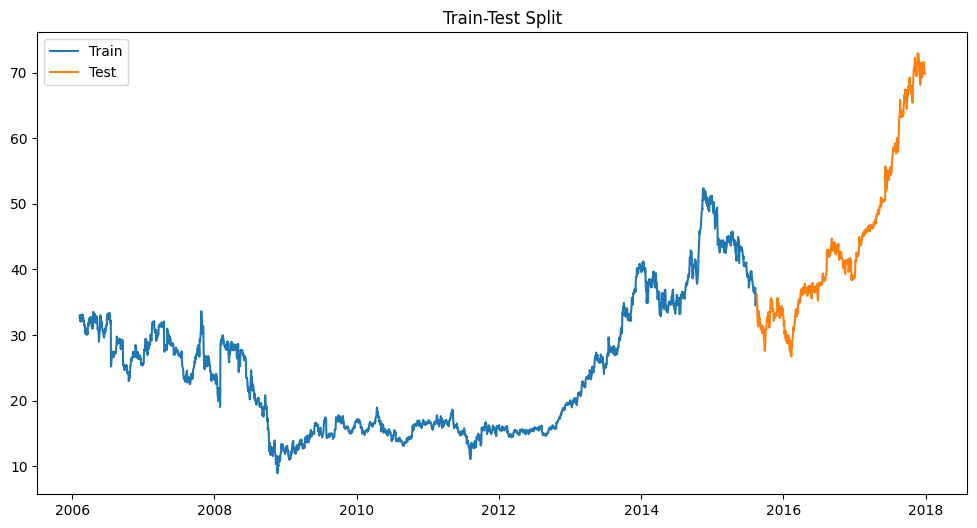

In [43]:
print("\n=== Data Summary ===")
print(f"Original shape: {df.shape}")
print(f"Train shapes - ML: {X_train_scaled.shape}, TF: {X_train_seq.shape}")
print(f"Test shapes - ML: {X_test_scaled.shape}, TF: {X_test_seq.shape}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test')
plt.title("Train-Test Split")
plt.legend()
plt.show()

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
print("Input shapes:")
print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

Input shapes:
Train: (2395, 9), Test: (599, 9)


In [48]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'metrics': {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }
    }
    print(f"{name} Performance:")
    for metric, value in results[name]['metrics'].items():
        print(f"{metric}: {value:.4f}")


Training Linear Regression...
Linear Regression Performance:
MSE: 0.2416
RMSE: 0.4915
MAE: 0.3316
R2: 0.9984

Training Random Forest...
Random Forest Performance:
MSE: 62.2126
RMSE: 7.8875
MAE: 5.6568
R2: 0.5937

Training XGBoost...
XGBoost Performance:
MSE: 58.1531
RMSE: 7.6258
MAE: 5.0461
R2: 0.6202


In [49]:
metrics_df = pd.DataFrame(
    {name: res['metrics'] for name, res in results.items()}
).T
print("\nModel Comparison:")
print(metrics_df.sort_values('RMSE'))


Model Comparison:
                         MSE      RMSE       MAE        R2
Linear Regression   0.241573  0.491501  0.331568  0.998422
XGBoost            58.153056  7.625815  5.046065  0.620179
Random Forest      62.212647  7.887499  5.656791  0.593664


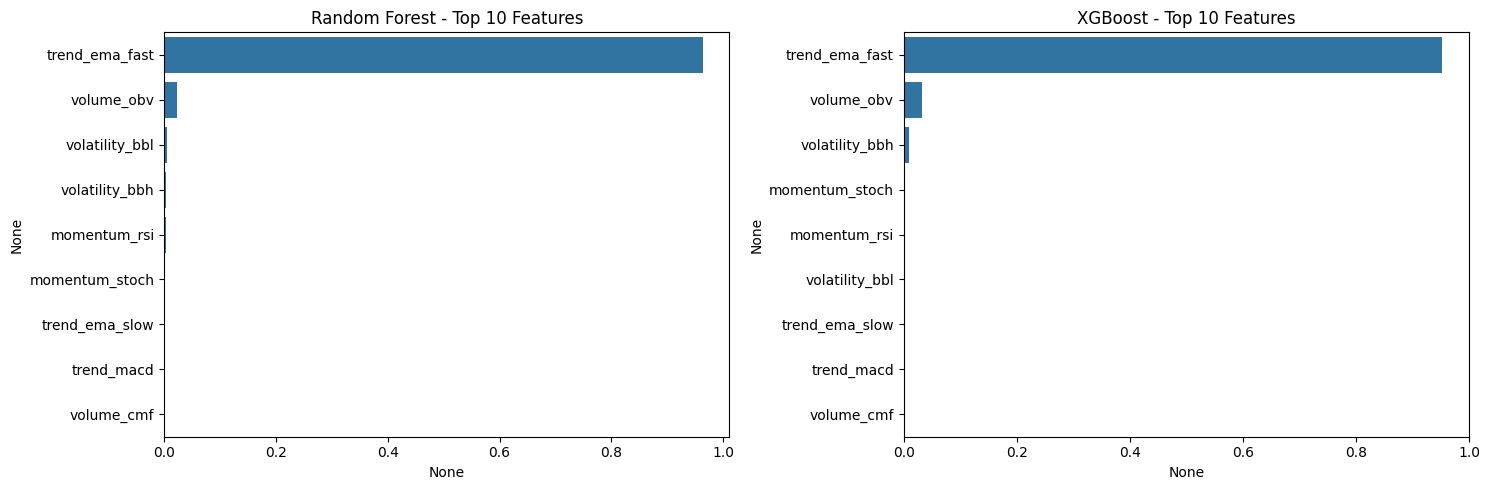

In [50]:
plt.figure(figsize=(15, 5))
for i, (name, res) in enumerate(results.items()):
    if hasattr(res['model'], 'feature_importances_'):
        plt.subplot(1, 2, i)
        feat_importances = pd.Series(
            res['model'].feature_importances_,
            index=X_train.columns
        ).sort_values(ascending=False)
        sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10])
        plt.title(f"{name} - Top 10 Features")
plt.tight_layout()
plt.show()

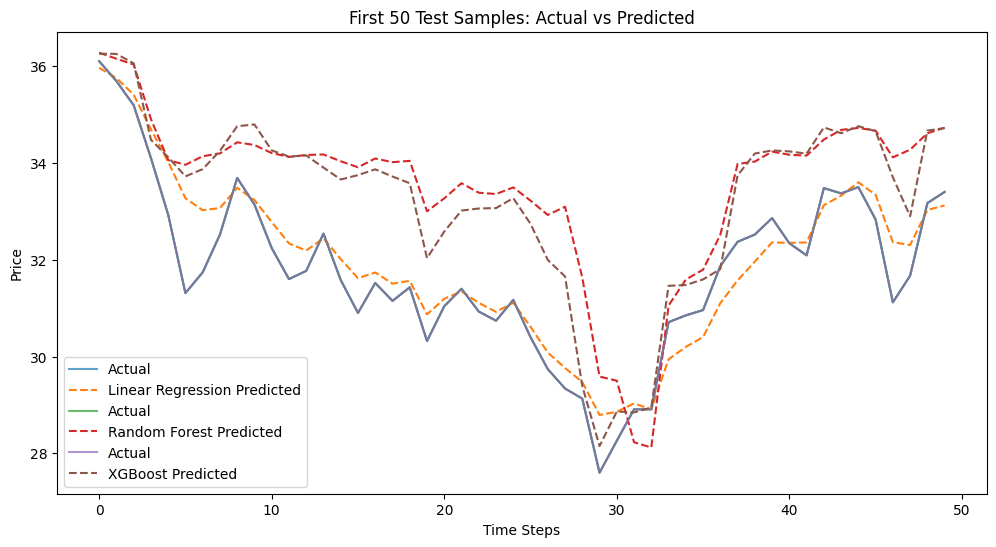

In [51]:
plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(y_test.values[:50], alpha=0.7, label='Actual')
    plt.plot(res['predictions'][:50], linestyle='--', label=f'{name} Predicted')
plt.title("First 50 Test Samples: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

In [52]:
best_model_name = min(results, key=lambda x: results[x]['metrics']['RMSE'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} (RMSE: {results[best_model_name]['metrics']['RMSE']:.4f})")


Best model: Linear Regression (RMSE: 0.4915)


ARIMA MODEL

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [56]:
ts = df['Close'].dropna()
print(f"Original time series length: {len(ts)}")

Original time series length: 2994


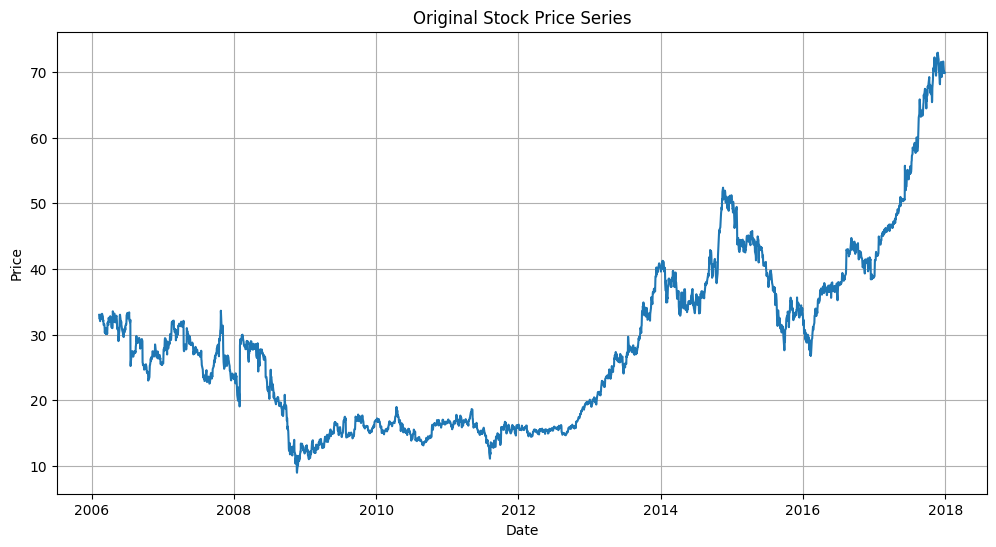

In [57]:
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.title('Original Stock Price Series')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid()
plt.show()

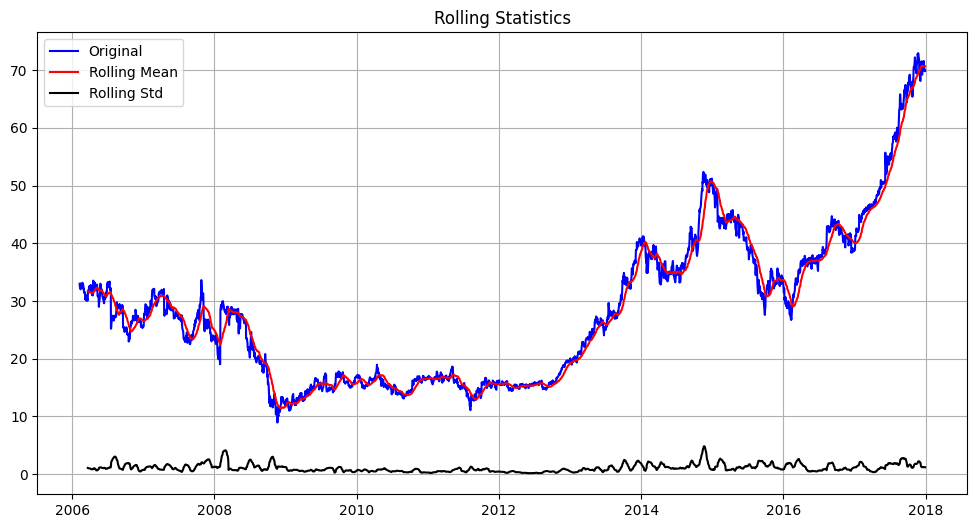

ADF Statistic: 1.0473888800970894
p-value: 0.9947416240975783
Critical Values: {'1%': -3.4325507240185105, '5%': -2.862512336314338, '10%': -2.5672876007125645}
Series is non-stationary


In [58]:
def test_stationarity(series, window=30):
    rolmean = series.rolling(window).mean()
    rolstd = series.rolling(window).std()
    
    plt.figure(figsize=(12,6))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title('Rolling Statistics')
    plt.grid()
    plt.show()
    
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    return result[1] > 0.05

is_non_stationary = test_stationarity(ts)
print(f"Series is {'non-' if is_non_stationary else ''}stationary")

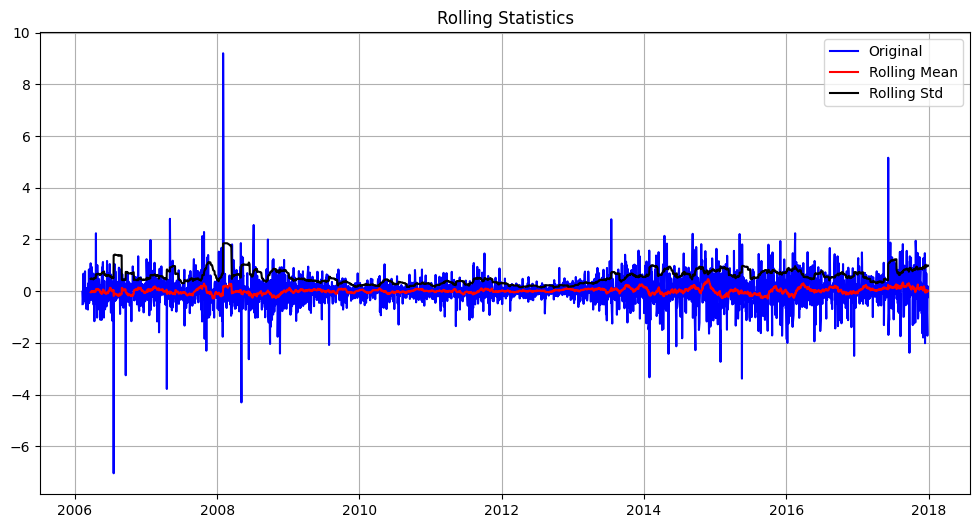

ADF Statistic: -12.34942855673646
p-value: 5.870960010486452e-23
Critical Values: {'1%': -3.4325507240185105, '5%': -2.862512336314338, '10%': -2.5672876007125645}


In [59]:
if is_non_stationary:
    ts_diff = ts.diff().dropna()
    test_stationarity(ts_diff)
else:
    ts_diff = ts.copy()

In [ ]:
auto_model = pm.auto_arima(ts,seasonal=False,stepwise=True,suppress_warnings=True,trace=True)
print(auto_model.summary())
p, d, q = auto_model.order


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=7803.649, Time=0.38 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6937.754, Time=0.33 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7801.649, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6613.035, Time=0.45 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6403.049, Time=0.66 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=6284.369, Time=0.96 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6193.282, Time=1.04 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=6191.282, Time=0.46 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=6282.369, Time=0.45 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=2.62 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=2.28 s

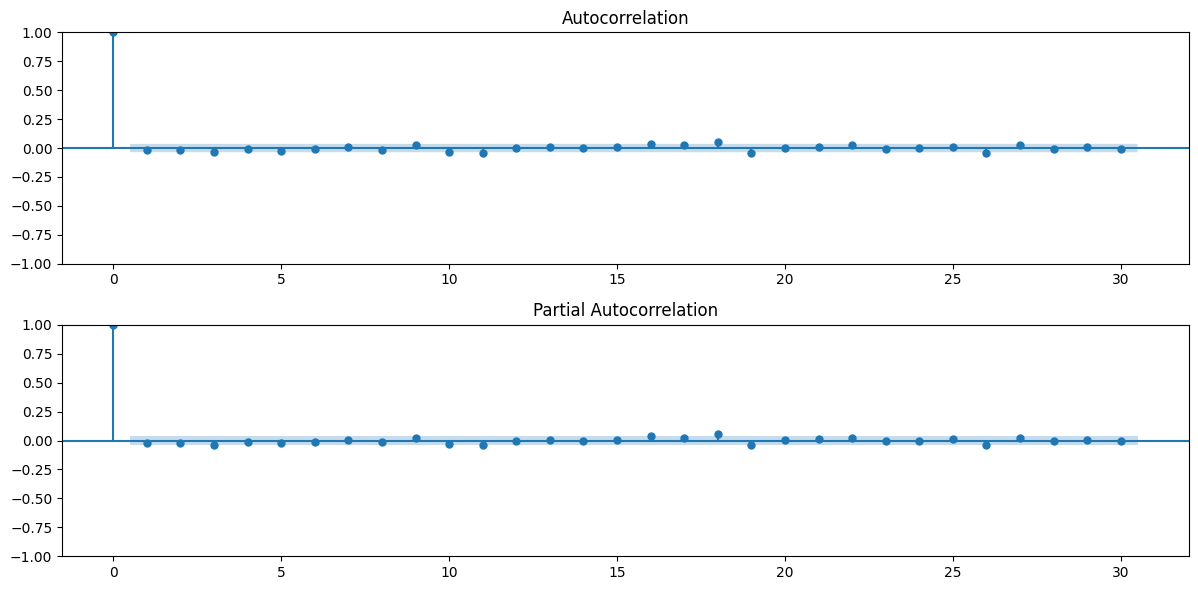

In [61]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plot_acf(ts_diff, lags=30, ax=plt.gca())
plt.subplot(2,1,2)
plot_pacf(ts_diff, lags=30, ax=plt.gca())
plt.tight_layout()
plt.show()

In [63]:
train_size = int(len(ts)*0.8)
train, test = ts[:train_size], ts[train_size:]
model = ARIMA(train, order=(p,d,q))
fitted_model = model.fit()
print(fitted_model.summary())

c:\Users\Mano likhith\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mano likhith\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mano likhith\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2395
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -2354.484
Date:                Fri, 20 Jun 2025   AIC                           4720.968
Time:                        23:31:56   BIC                           4755.650
Sample:                             0   HQIC                          4733.587
                               - 2395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8205      0.014    -59.015      0.000      -0.848      -0.793
ar.L2         -0.6707      0.018    -36.839      0.000      -0.706      -0.635
ar.L3         -0.5080      0.019    -26.205      0.0

In [64]:
forecast = fitted_model.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

c:\Users\Mano likhith\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Mano likhith\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [66]:
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast_values)
print(f"\nEvaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Evaluation Metrics:
MSE: 65.6657
RMSE: 8.1034
MAE: 6.1496


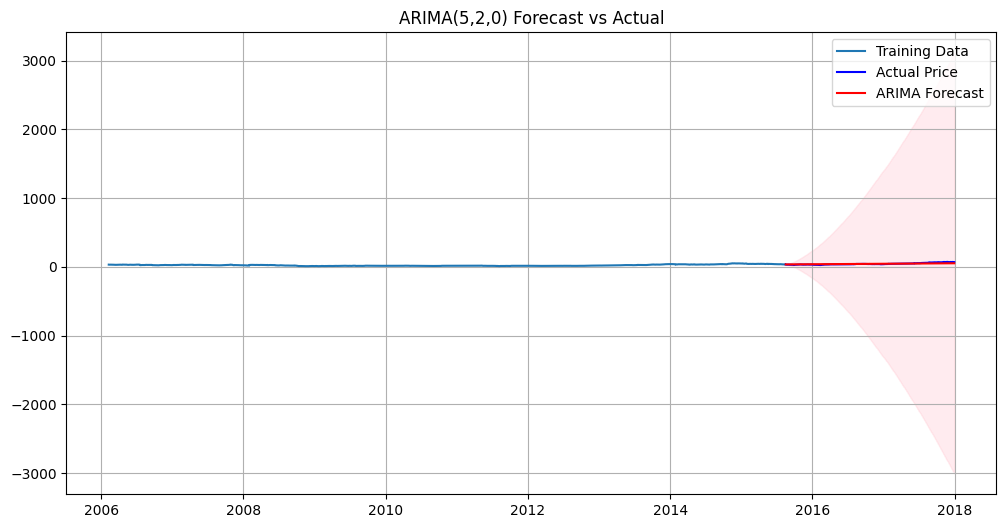

In [68]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Price', color='blue')
plt.plot(test.index, forecast_values, label='ARIMA Forecast', color='red')
plt.fill_between(test.index,conf_int.iloc[:,0],conf_int.iloc[:,1],color='pink', alpha=0.3)
plt.title(f'ARIMA({p},{d},{q}) Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()

c:\Users\Mano likhith\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


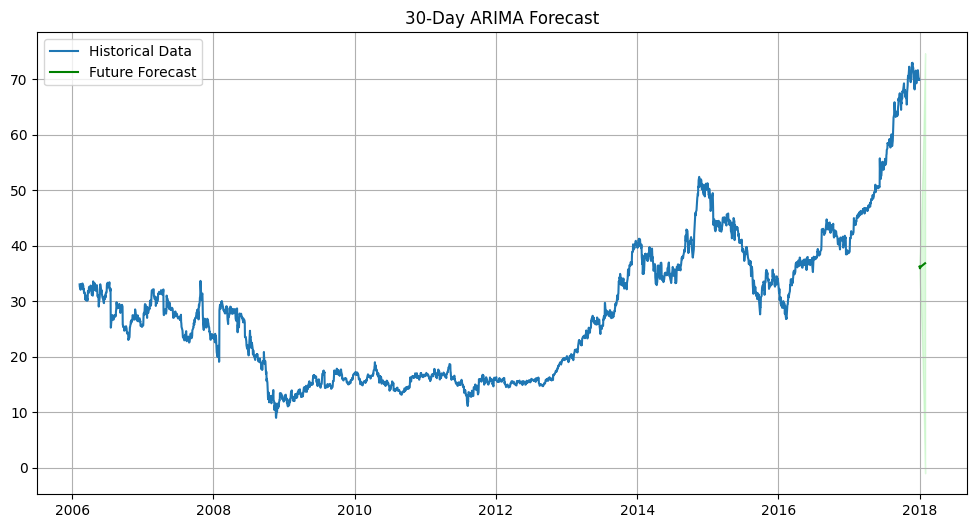

In [73]:
future_steps = 30
future_forecast = fitted_model.get_forecast(steps=future_steps)
future_values = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date,periods=future_steps+1,inclusive='right')
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts, label='Historical Data')
plt.plot(future_dates, future_values, label='Future Forecast', color='green')
plt.fill_between(future_dates,future_conf_int.iloc[:,0],future_conf_int.iloc[:,1],color='lightgreen', alpha=0.3)
plt.title(f'{future_steps}-Day ARIMA Forecast')
plt.legend()
plt.grid()
plt.show()

SARIMA MODEL

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [75]:
ts = df['Close'].dropna().asfreq('D').ffill()
print(f"Time series length: {len(ts)}")

Time series length: 4343


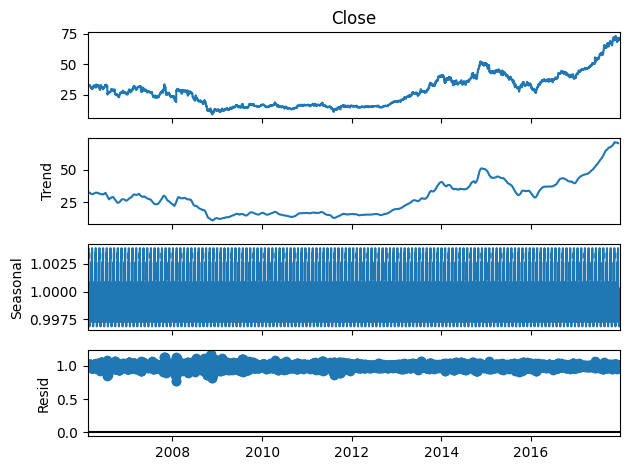

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts, model='multiplicative', period=30)
result.plot()
plt.show()

In [77]:
auto_model = pm.auto_arima(ts,seasonal=True,m=7,stepwise=True,suppress_warnings=True,trace=True,error_action='ignore')
print(auto_model.summary())
order = auto_model.order
seasonal_order = auto_model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=inf, Time=12.08 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=9765.452, Time=0.34 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=8438.990, Time=0.57 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=2.85 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=8437.559, Time=0.18 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=8439.004, Time=0.48 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=8440.775, Time=2.00 sec
 ARIMA(2,2,0)(0,0,0)[7]             : AIC=7856.928, Time=0.26 sec
 ARIMA(2,2,0)(1,0,0)[7]             : AIC=7858.574, Time=0.64 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=7858.585, Time=0.61 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=7860.238, Time=2.11 sec
 ARIMA(3,2,0)(0,0,0)[7]             : AIC=7611.395, Time=0.49 sec
 ARIMA(3,2,0)(1,0,0)[7]             : AIC=7613.353, Time=0.78 sec
 ARIMA(3,2,0)(0,0,1)[7]             : AIC=7613.354, Time=0.70 sec
 ARIMA(3,2,0)(1,0,1)[7]             : AIC=

In [78]:
train_size = int(len(ts)*0.8)
train, test = ts[:train_size], ts[train_size:]

In [79]:
model = SARIMAX(train,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
fitted_model = model.fit(disp=0)
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3474
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -2767.334
Date:                Sat, 21 Jun 2025   AIC                           5546.667
Time:                        23:02:13   BIC                           5583.573
Sample:                    02-08-2006   HQIC                          5559.845
                         - 08-13-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8331      0.010    -81.977      0.000      -0.853      -0.813
ar.L2         -0.6675      0.014    -48.161      0.000      -0.695      -0.640
ar.L3         -0.4691      0.015    -30.269      0.0

In [80]:
forecast = fitted_model.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

In [81]:
metrics = {
    'MSE': mean_squared_error(test, forecast_values),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_values)),
    'MAE': mean_absolute_error(test, forecast_values)
}
print("\nEvaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Evaluation Metrics:
MSE: 4476.5392
RMSE: 66.9069
MAE: 55.0568


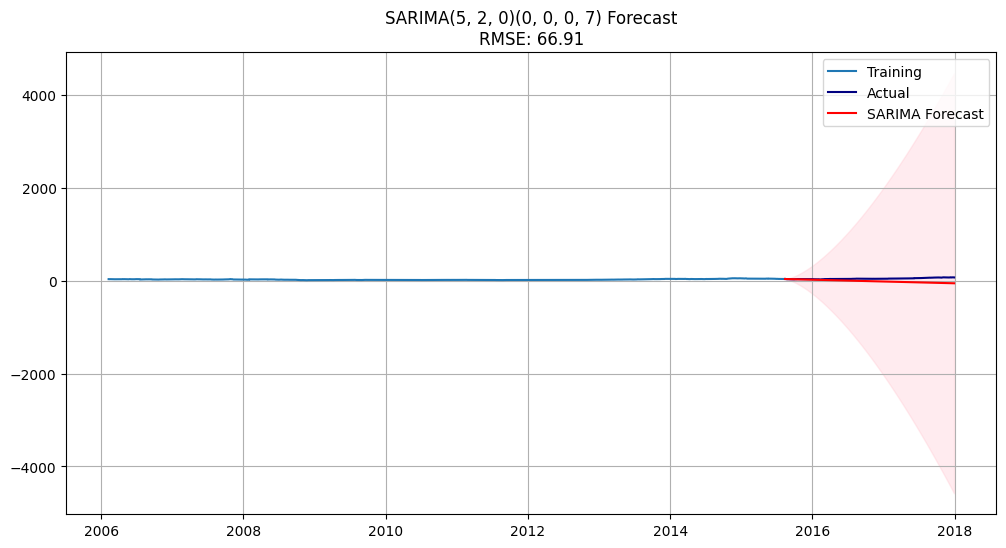

In [82]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='navy')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(test.index,
                conf_int.iloc[:,0],
                conf_int.iloc[:,1],
                color='pink', alpha=0.3)
plt.title(f'SARIMA{order}{seasonal_order} Forecast\nRMSE: {metrics["RMSE"]:.2f}')
plt.legend()
plt.grid()
plt.show()

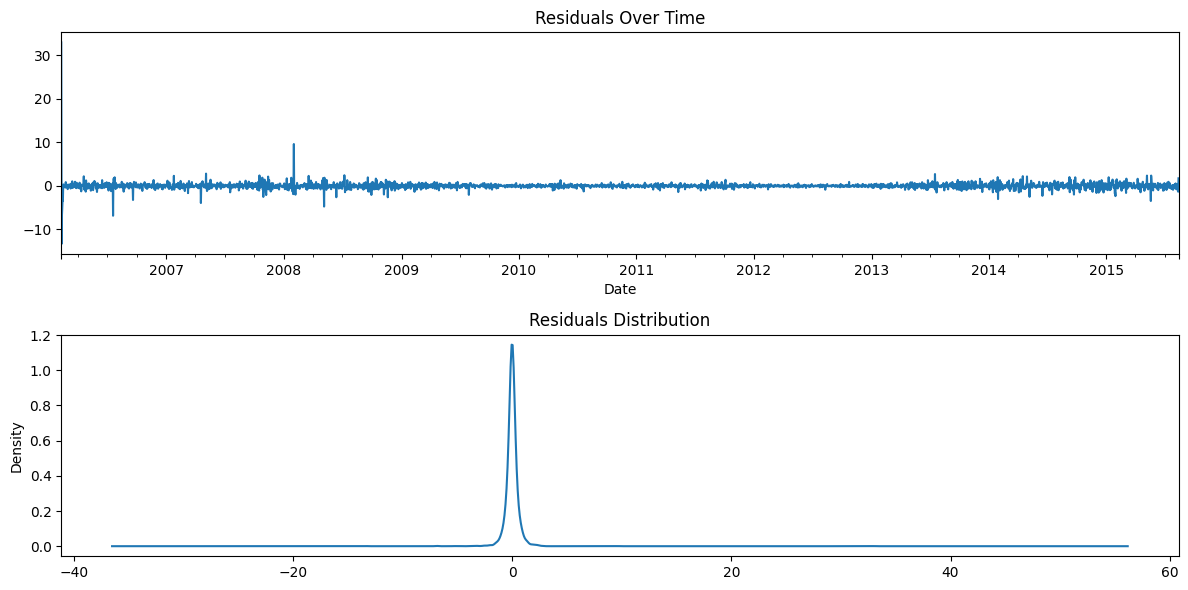

In [83]:
residuals = fitted_model.resid
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
residuals.plot()
plt.title('Residuals Over Time')
plt.subplot(2,1,2)
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()


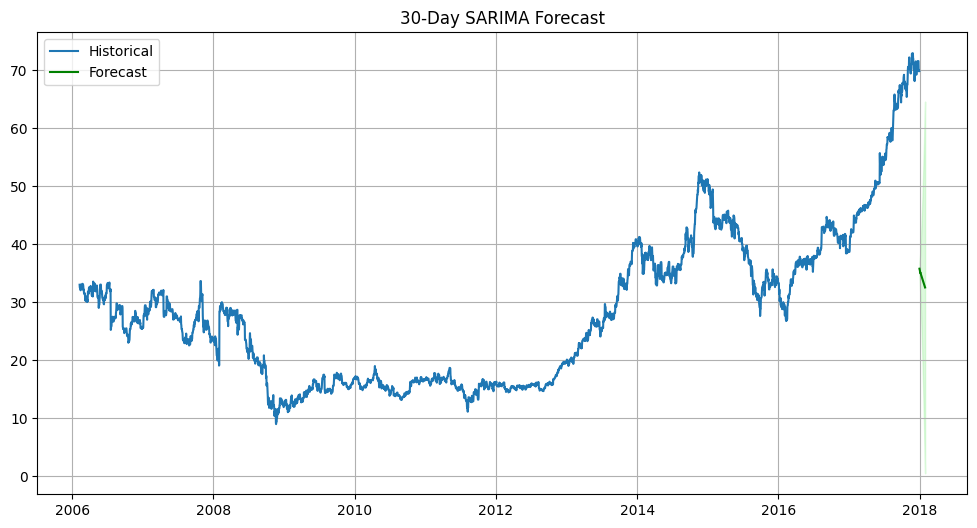

In [84]:
future_steps = 30
future_forecast = fitted_model.get_forecast(steps=future_steps)
future_values = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()

future_dates = pd.date_range(
    start=ts.index[-1],
    periods=future_steps+1,
    inclusive='right'
)

plt.figure(figsize=(12,6))
plt.plot(ts.index, ts, label='Historical')
plt.plot(future_dates, future_values, label='Forecast', color='green')
plt.fill_between(future_dates,
                future_conf_int.iloc[:,0],
                future_conf_int.iloc[:,1],
                color='lightgreen', alpha=0.3)
plt.title(f'{future_steps}-Day SARIMA Forecast')
plt.legend()
plt.grid()
plt.show()

LSTM MODEL

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [91]:
data = df['Close'].values.reshape(-1, 1)

In [92]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [93]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [94]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [95]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [96]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100

74/74 [==============================] - 17s 72ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 2/100
74/74 [==============================] - 4s 53ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 3/100
74/74 [==============================] - 4s 52ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/100
74/74 [==============================] - 4s 52ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/100
74/74 [==============================] - 4s 54ms/step - loss: 0.0011 - val_loss: 4.4582e-04
Epoch 6/100
74/74 [==============================] - 4s 55ms/step - loss: 8.9291e-04 - val_loss: 0.0012
Epoch 7/100
74/74 [==============================] - 4s 52ms/step - loss: 8.5790e-04 - val_loss: 6.9646e-04
Epoch 8/100
74/74 [==============================] - 4s 52ms/step - loss: 8.0924e-04 - val_loss: 6.0667e-04
Epoch 9/100
74/74 [==============================] - 4s 51ms/step - loss: 8.2303e-04 - val_loss: 7.2176e-04
Epoch 10/100
74/74 [==============================] - 4s 51ms/step

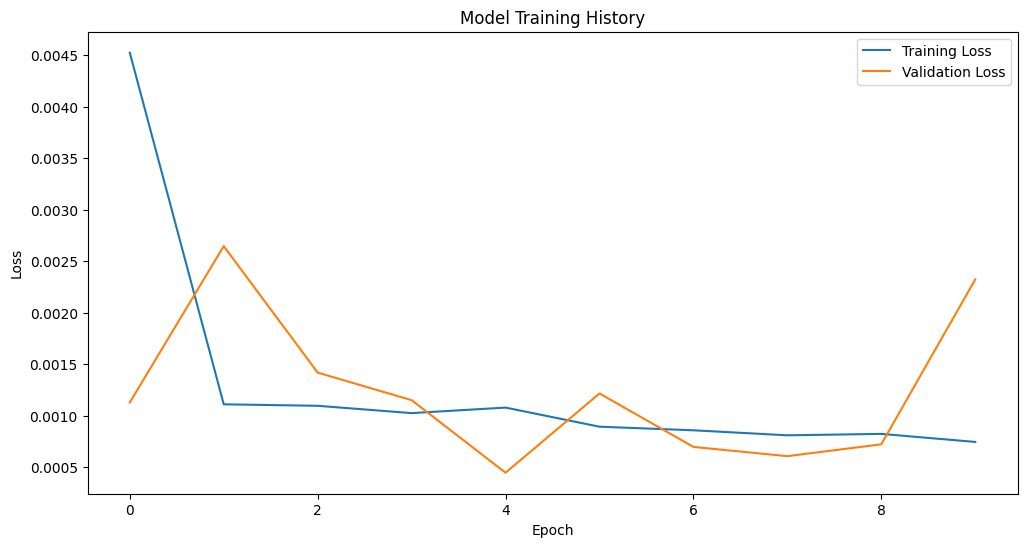

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19/19 [==============================] - 0s 19ms/step


In [99]:
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [100]:
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    return mse, rmse, mae

In [101]:
train_mse, train_rmse, train_mae = calculate_metrics(y_train_actual, train_predict)
test_mse, test_rmse, test_mae = calculate_metrics(y_test_actual, test_predict)

In [102]:
print("\nTraining Metrics:")
print(f"MSE: {train_mse:.2f}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
print("\nTest Metrics:")
print(f"MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")


Training Metrics:
MSE: 2.08, RMSE: 1.44, MAE: 1.06

Test Metrics:
MSE: 9.51, RMSE: 3.08, MAE: 2.58


In [103]:
train_idx = df.index[:split+SEQ_LENGTH]
test_idx = df.index[split+SEQ_LENGTH:split+SEQ_LENGTH+len(test_predict)]

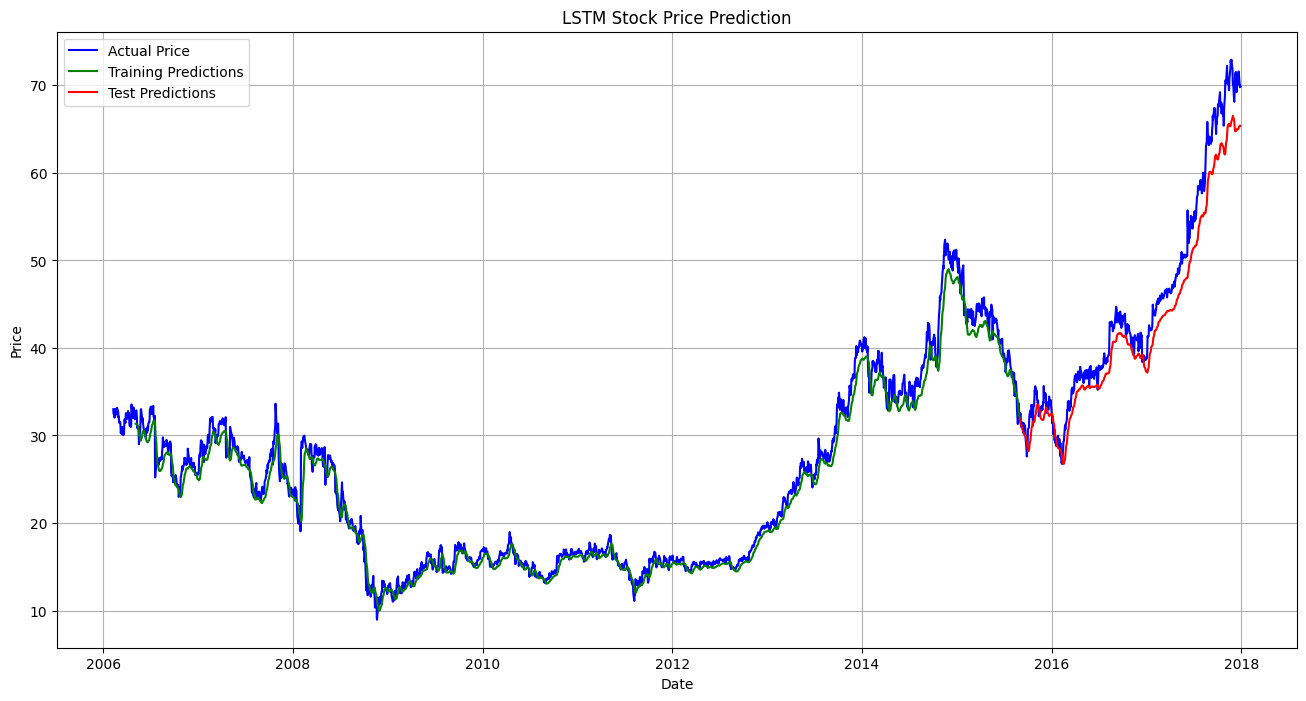

In [104]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Actual Price', color='blue')
plt.plot(train_idx[SEQ_LENGTH:], train_predict, label='Training Predictions', color='green')
plt.plot(test_idx, test_predict, label='Test Predictions', color='red')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [105]:
def forecast_future(model, last_sequence, days=30):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        next_pred = model.predict(current_sequence.reshape(1, SEQ_LENGTH, 1))
        future_predictions.append(next_pred[0,0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
        
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [106]:
last_sequence = scaled_data[-SEQ_LENGTH:]

In [107]:
future_days = 30
future_prices = forecast_future(model, last_sequence, future_days)

1/1 [==============================] - 0s 45ms/step


In [108]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days+1, freq='B')[1:]

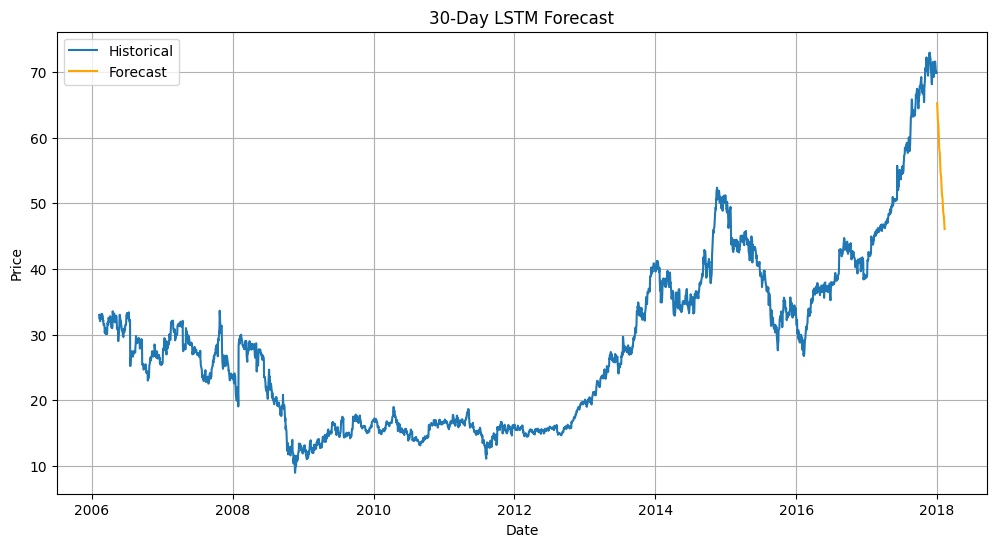

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical')
plt.plot(future_dates, future_prices, label='Forecast', color='orange')
plt.title(f'{future_days}-Day LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [131]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf
from plotly import graph_objects as go

In [ ]:
def prepare_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    df = df[['Close']].reset_index()
    df.columns = ['ds', 'y']
    
    df['daily_return'] = df['y'].pct_change()
    df['volatility'] = df['daily_return'].rolling(7).std()
    
    df = df[df['ds'].dt.dayofweek < 5].dropna()
    
    return df

In [112]:
df = prepare_data('AAPL', '2020-01-01', '2023-12-31')

C:\Users\Mano likhith\AppData\Local\Temp\ipykernel_22508\2926379272.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


In [113]:
train_size = int(0.8 * len(df))
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"Train period: {train['ds'].min().date()} to {train['ds'].max().date()}")
print(f"Test period: {test['ds'].min().date()} to {test['ds'].max().date()}")


Train period: 2020-01-13 to 2023-03-15
Test period: 2023-03-16 to 2023-12-29


In [114]:
model = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
    holidays=None
)

In [115]:
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [116]:
model.add_regressor('daily_return')
model.add_regressor('volatility')

In [117]:
model.fit(train)

20:06:53 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
future = model.make_future_dataframe(periods=len(test), freq='D')
future = future.merge(df[['ds', 'daily_return', 'volatility']], on='ds', how='left')

In [120]:
future['daily_return'] = future['daily_return'].fillna(method='ffill')
future['volatility'] = future['volatility'].fillna(method='ffill')

C:\Users\Mano likhith\AppData\Local\Temp\ipykernel_22508\1946756804.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['daily_return'] = future['daily_return'].fillna(method='ffill')
C:\Users\Mano likhith\AppData\Local\Temp\ipykernel_22508\1946756804.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['volatility'] = future['volatility'].fillna(method='ffill')


In [121]:
print("Missing values in future dataframe:")
print(future.isnull().sum())

Missing values in future dataframe:
ds              0
daily_return    0
volatility      0
dtype: int64


In [122]:
forecast = model.predict(future)

In [123]:
results = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(
    df.set_index('ds')['y'])

In [125]:
test_results = results.iloc[train_size:].dropna()

In [126]:
assert len(test_results['y']) == len(test_results['yhat']), "Mismatched lengths"

In [127]:
metrics = {
    'MSE': mean_squared_error(test_results['y'], test_results['yhat']),
    'RMSE': np.sqrt(mean_squared_error(test_results['y'], test_results['yhat'])),
    'MAE': mean_absolute_error(test_results['y'], test_results['yhat']),
    'MAPE': np.nanmean(np.abs((test_results['y'] - test_results['yhat']) / test_results['y'])) * 100
}

print("Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Evaluation Metrics:
MSE: 151.5330
RMSE: 12.3099
MAE: 10.3449
MAPE: 5.8388


In [138]:
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2023-12-31")[['Close']]
df = df.reset_index()
df.columns = ['ds', 'y']

C:\Users\Mano likhith\AppData\Local\Temp\ipykernel_22508\2510320533.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2023-12-31")[['Close']]
[*********************100%***********************]  1 of 1 completed


In [139]:
model = Prophet()
model.fit(df)

20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing


In [140]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


In [141]:
fig = go.Figure()

In [142]:
fig.add_trace(go.Scatter(
    x=df['ds'],
    y=df['y'],
    name='Actual',
    mode='markers',
    marker=dict(color='blue')
))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'blue'},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2023-12-27T00:00:00.000000000',
                          '2023-12-28T00:00:00.000000000', '2023-12-29T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('AAAAgLsnUkAAAABAjPpRQAAAAAA5H1' ... 'Cg3fdnQAAAAMCGBWhAAAAAoCvkZ0A='),
                    'dtype': 'f8'}}],
    'layout': {'template': '...'}
})

In [143]:
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    name='Forecast',
    line=dict(color='red')
))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'blue'},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2023-12-27T00:00:00.000000000',
                          '2023-12-28T00:00:00.000000000', '2023-12-29T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('AAAAgLsnUkAAAABAjPpRQAAAAAA5H1' ... 'Cg3fdnQAAAAMCGBWhAAAAAoCvkZ0A='),
                    'dtype': 'f8'}},
             {'line': {'color': 'red'},
              'name': 'Forecast',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2024-01-26T00:00:00.000000000',
                          '2024-01-27T00:00:00.000000000', '2024-01-28T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('jsFHDAn6UUB+IozC+OZRQNASbb8Syl' ... 'ozDaxoQBpdfecvpWhApccHf063aEA='),
                    'dtype': 'f8'}}],
    'layout': {'template': '...'}
})

In [144]:
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    fill=None,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'blue'},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2023-12-27T00:00:00.000000000',
                          '2023-12-28T00:00:00.000000000', '2023-12-29T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('AAAAgLsnUkAAAABAjPpRQAAAAAA5H1' ... 'Cg3fdnQAAAAMCGBWhAAAAAoCvkZ0A='),
                    'dtype': 'f8'}},
             {'line': {'color': 'red'},
              'name': 'Forecast',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2024-01-26T00:00:00.000000000',
                          '2024-01-27T00:00:00.000000000', '2024-01-28T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('jsFHDAn6UUB+IozC+OZRQNASbb8Syl' ... 'ozDaxoQBpdfecvpWhApccHf063aEA='),
                    'dtype': 'f8'}},
             {'line': {'width': 0},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2024-01-26T00:00:00.000000000',
                          '2024-01-27T00:00:00.000000000', '2024-01-28T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('Hzscl34JVEDt9RM/HhFUQOVRIiL81V' ... '6hrLZpQBWEP68Xw2lAQzasxvnEaUA='),
                    'dtype': 'f8'}}],
    'layout': {'template': '...'}
})

In [145]:
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    name='Uncertainty'
))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'blue'},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2023-12-27T00:00:00.000000000',
                          '2023-12-28T00:00:00.000000000', '2023-12-29T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('AAAAgLsnUkAAAABAjPpRQAAAAAA5H1' ... 'Cg3fdnQAAAAMCGBWhAAAAAoCvkZ0A='),
                    'dtype': 'f8'}},
             {'line': {'color': 'red'},
              'name': 'Forecast',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2024-01-26T00:00:00.000000000',
                          '2024-01-27T00:00:00.000000000', '2024-01-28T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('jsFHDAn6UUB+IozC+OZRQNASbb8Syl' ... 'ozDaxoQBpdfecvpWhApccHf063aEA='),
                    'dtype': 'f8'}},
             {'line': {'width': 0},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2024-01-26T00:00:00.000000000',
                          '2024-01-27T00:00:00.000000000', '2024-01-28T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('Hzscl34JVEDt9RM/HhFUQOVRIiL81V' ... '6hrLZpQBWEP68Xw2lAQzasxvnEaUA='),
                    'dtype': 'f8'}},
             {'fill': 'tonexty',
              'line': {'width': 0},
              'mode': 'lines',
              'name': 'Uncertainty',
              'type': 'scatter',
              'x': array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
                          '2020-01-06T00:00:00.000000000', ..., '2024-01-26T00:00:00.000000000',
                          '2024-01-27T00:00:00.000000000', '2024-01-28T00:00:00.000000000'],
                         dtype='datetime64[ns]'),
              'y': {'bdata': ('7FtpUKe7T0ASY8/Tk5tPQPqH1soCgk' ... 'SIN6hnQGo6gE7JlWdAcLMRYSOhZ0A='),
                    'dtype': 'f8'}}],
    'layout': {'template': '...'}
})

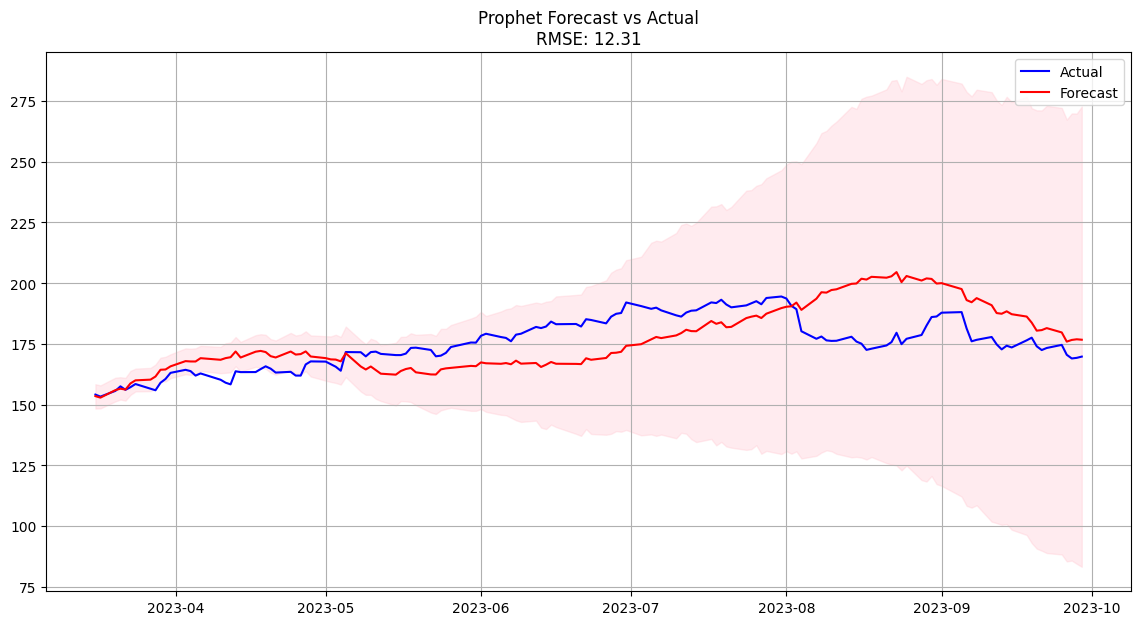

In [148]:
plt.figure(figsize=(14, 7))
plt.plot(test_results.index, test_results['y'], label='Actual', color='blue')
plt.plot(test_results.index, test_results['yhat'], label='Forecast', color='red')
plt.fill_between(test_results.index,
                test_results['yhat_lower'],
                test_results['yhat_upper'],
                color='pink', alpha=0.3)
plt.title(f'Prophet Forecast vs Actual\nRMSE: {metrics["RMSE"]:.2f}')
plt.legend()
plt.grid()
plt.show()

In [149]:
future_days = model.make_future_dataframe(periods=30, freq='D')


In [151]:
future_forecast = model.predict(future_days)


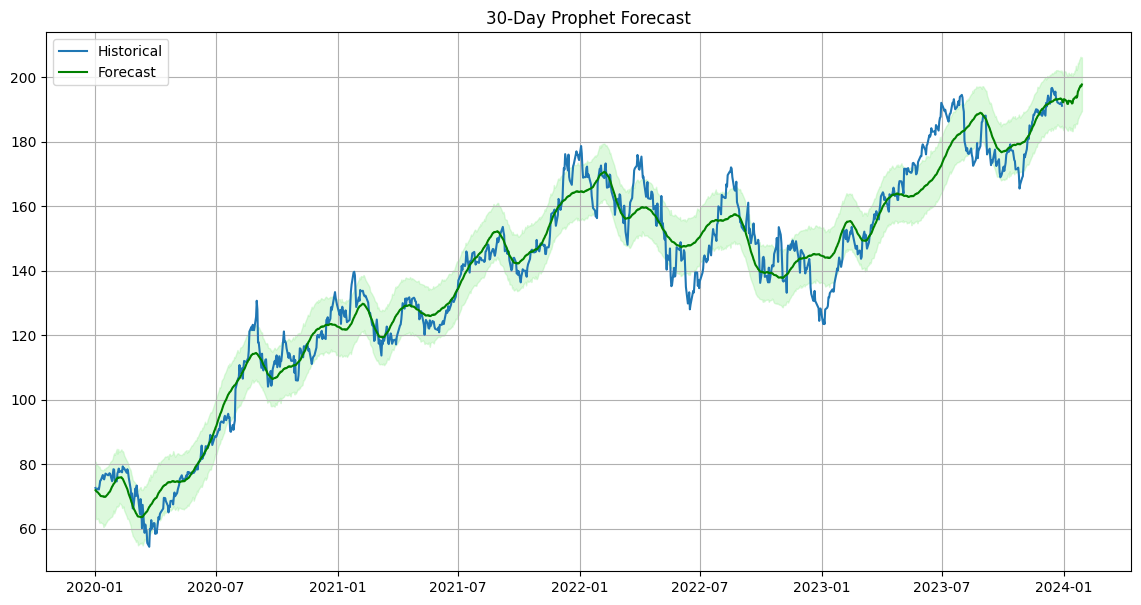

In [152]:
plt.figure(figsize=(14, 7))
plt.plot(df['ds'], df['y'], label='Historical')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast', color='green')
plt.fill_between(future_forecast['ds'],
                future_forecast['yhat_lower'],
                future_forecast['yhat_upper'],
                color='lightgreen', alpha=0.3)
plt.title('30-Day Prophet Forecast')
plt.legend()
plt.grid()
plt.show()